# Hybrid Approach for Cold-Start Problem in E-Commerce Recommendation System Using Regression

### Summary Project
In this project, we address the cold-start problem commonly encountered in e-commerce recommendation systems. The challenge arises when users have not provided ratings for products they have purchased, resulting in missing data that limits the effectiveness of collaborative filtering algorithms. To overcome this, we use a regression-based approach with XGBRegressor to predict missing ratings. Key features such as delivery time, freight value, and normalized price are utilized to model user preferences and predict ratings for transactions where no user feedback is available.

Once the missing ratings are filled, we can generate a complete dataset with no null values. This dataset serves as input for a collaborative filtering approach using Singular Value Decomposition (SVD) matrix factorization. By applying this method, the model predicts the top 10 highest-rated items for each user, offering personalized product recommendations. This hybrid approach ensures the recommendation system is robust even in scenarios with limited user interactions, providing a solution that leverages both content-based and collaborative filtering techniques to improve recommendation accuracy.

### About Dataset
The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates

url dataset = https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

# 1. Import Library & Dataset

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from xgboost import XGBRegressor
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV as regCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from xgboost import XGBRegressor
import surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV as svdCV
from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions

## 2. Regression Model 

## 2.1 Data Preparation

In [3]:
# Import the required datasets one by one
data1=pd.read_csv('dataset/olist_order_items_dataset.csv')
data2=pd.read_csv('dataset/olist_order_payments_dataset.csv')
data3=pd.read_csv('dataset/olist_order_reviews_dataset.csv')
data4=pd.read_csv('dataset/olist_orders_dataset.csv')
data5=pd.read_csv('dataset/olist_products_dataset.csv')
pd.set_option('display.max_columns', None)

In [4]:
# Show column each dataset 
print(f'data1 = {data1.columns}\n')
print(f'data2 = {data2.columns}\n')
print(f'data3 = {data3.columns}\n')
print(f'data4 = {data3.columns}\n')
print(f'data5 = {data4.columns}')

data1 = Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

data2 = Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

data3 = Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

data4 = Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

data5 = Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


In [5]:
# Join multiple tables with foreign key column 'oder_id'
df=pd.merge(data1,data4,on='order_id',how='outer')
df=pd.merge(df,data2,on='order_id', how='outer')
df=pd.merge(df,data3.iloc[:,[1,2]],on='order_id',how='outer')
df=pd.merge(df,data5.iloc[:,[0,1]],on='product_id',how='outer')

## 2.2 Data Cleaning

In [6]:
# Filter completed orders
df=df[(df.order_purchase_timestamp.notnull())&(df.order_delivered_customer_date.notnull())].reset_index(drop=True)

# Fill missing product categories
df['product_category_name'] = df['product_category_name'].fillna('other')

# Make sure date column in datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

## 2.3 Feature Engineering

In [7]:
# Create delivery time time with calcualte difference time purchased and time delivered 
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['delivery_time'] = df['delivery_time'].dt.total_seconds() / 86400

# Calculate mean price per category  
df['price_mean'] = df.groupby('product_category_name')['price'].transform('mean')

# Normalize price column
df['price_normal'] = df['price'] / df['price_mean']

# Take column used for predict missing rating
df_features = df[['delivery_time','freight_value','price_normal','review_score']]

## 2.4 Feature Splitting

In [8]:
# Split data with rating clean and rating null
df_null = df_features[df_features.review_score.isnull()]
df_clean = df_features[df_features.review_score.notnull()]

# Split 
X = df_clean.iloc[:,:-1]
y = df_clean.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2.5 Feature Scaling

In [9]:
# Buat objek StandardScaler
scaler = StandardScaler()
features = X_train.columns

# Fit scaler pada X_train
scaler.fit(X_train)

# Transformasi variabel tersebut dengan scaler yang telah di fit
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 2.6 Model Training

In [ ]:
# Initialize the XGBRegressor model
model = XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='rmse')

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],    # Rentang nilai untuk n_estimators
    'max_depth': [3, 5, 7, 9, 10],                  # Rentang nilai untuk max_depth
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3],            # Rentang nilai untuk eta (learning rate)
}

# Setup GridSearchCV with verbosity to track progress
grid_search = regCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3, 
                    scoring='neg_root_mean_squared_error')

# Fit the model with grid search
grid_search.fit(X_train, y_train, verbose=True)

## 2.7 Model Evaluation

In [100]:
# Retrieve the best result from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the performance of the best model
y_pred = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best RMSE: {val_rmse}")
print(f"Best Parameters: {best_params}")

Best RMSE: 1.1972305667630123
Best Parameters: {'eta': 0.05, 'max_depth': 10, 'n_estimators': 500}


In [101]:
# Compare the prediction results with the actual values
results = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred})
results

,Actual,Predicted
0,5.0,4.488035
1,3.0,4.110348
2,4.0,4.247641
3,5.0,4.572317
4,5.0,4.287142
...,...,...
22968,4.0,4.514670
22969,5.0,3.959340
22970,5.0,4.307520
22971,5.0,4.046359


## 2.8 Model Application

In [77]:
# Retrieve the rating data that is null for prediction
X_predict = df_null[features]
X_predict_scaled = scaler.transform(X_predict)

# Predict the missing ratings
rating_predict = best_model.predict(X_predict_scaled)
X_predict['review_score'] = pd.Series(rating_predict, index=X_predict.index)

# Combine the original data with the predicted data
df_features_new = pd.concat([df_clean,X_predict]).sort_index()
df['rating'] = df_features_new['review_score']

To address the cold-start problem in our recommendation system, we first handled the missing ratings in the transaction data. Using the XGBRegressor model, we predicted the missing ratings based on features such as delivery time, freight value, and normalized price. This step allowed us to fill in the gaps in our dataset, enabling a more complete and robust dataset before proceeding to the collaborative filtering stage for generating personalized recommendations.

# 3. Recommendation Engine

## 3.1 Exploratory Data Analysis

In [82]:
# Prepare the data
data = df.copy()
data.rename({'customer_id':'userID','product_id':'itemID'},axis=1,inplace=True)
data = data[['userID', 'itemID', 'rating']]

<AxesSubplot:>

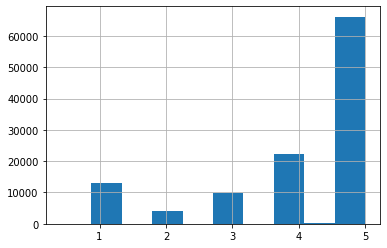

In [88]:
# Show rating distribution
data.rating.hist(bins=10)

In [97]:
# Show summary each columns 
data.describe()

,rating
count,115722.000000
mean,4.078083
std,1.345239
min,0.416365
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [96]:
# Show distinct unique value each column
for column in data.columns:
    unique_values = data[column].nunique()
    print(f'{column} : {unique_values}')

userID : 96476
itemID : 32214
rating : 681


## 3.2 Data Preparation

In [13]:
# Split the dataset into train and test sets
train, test = python_random_split(data,0.8,seed=42)
# Adjust rating scale if necessary
reader = Reader(rating_scale=(train.rating.min(), train.rating.max()))  
# Convert dataset to trainset
train_dataset = surprise.Dataset.load_from_df(train, reader=reader)
train_set = train_dataset.build_full_trainset()

## 3.3 Model Tuning

In [24]:
# Define the parameter grid
param_grid = {
    'n_factors': [100, 200, 300, 400, 500],        # Number of latent factors
    'n_epochs': [40],                              # Number of training epochs
    'lr_all': [0.002, 0.005, 0.01, 0.05, 0.1],     # Learning rate for all parameters
    'reg_all': [0.01, 0.025, 0.05, 0.1, 0.2]       # Regularization term for all parameters
}


gs_svd = svdCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1, joblib_verbose=3)
gs_svd.fit(train_dataset)  # Use the converted data for GridSearchCV

# Extract best RMSE score
best_rmse = gs_svd.best_score['rmse']
best_params = gs_svd.best_params['rmse']

print(f"Best RMSE score: {best_rmse}")
print(f"Best parameters: {best_params}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 22.8min


Best RMSE score: 1.1499265963241014
Best parameters: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.1, 'reg_all': 0.2}


[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed: 32.9min finished


## 3.4 Model Training

In [39]:
# Train SVD with best parameters
svd = SVD(**best_params)
svd.fit(train_set)

# Show y prediction
predictions = predict(svd, test, usercol='userID', itemcol='itemID')
predictions

,userID,itemID,prediction
0,9341fecaab3e912d71cf05c31ead299f,c82cf18016c429035d415a45a1546652,4.053377
1,615063e4a4d4fc2ef9cda7c7358e2d4e,8b199a0f183f8011403f53356c564d80,3.729317
2,c2a2fca81f9fa31bede9b92c5606bc7b,c0603988d17e4588dfce0f7f01978557,4.102088
3,8a31acd6bdd796b96b5cde8325da7c41,34dabb8af33b3756cf72df05fb327011,4.098395
4,574784507f8c418dc386a0961453a3c0,e0bb3159111d86828b5caef8725ff055,3.720514
...,...,...,...
23140,ce57da1d592e7f5a8606eca47d71664a,80f258d43a984e2e7af7f1e1163e4018,4.915475
23141,266413b8d0b525d23ebc87014a58603f,b3c60191c4d756abdf423e5b21eb91dc,4.080779
23142,4c44865a36098a8b24dba15c90f01511,76bb142328fba1ac3a1e2ba033171d94,4.080779
23143,a05f4c66baf8e2a458de2a45255bc3c1,7c77aa8ae608782aac8e7728acff92fb,3.598741


## 3.5 Model Evaluation

In [38]:
# Show evaluation model result
eval_rmse = rmse(test, predictions)
eval_mae = mae(test, predictions)
eval_rsquared = rsquared(test, predictions)
eval_exp_var = exp_var(test, predictions)
print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "rsquared:\t%f" % eval_rsquared,
      "exp var:\t%f" % eval_exp_var, sep='\n')

RMSE:		1.104499
MAE:		0.787093
rsquared:	0.364472
exp var:	0.364652


## 3.6 Generating Recommendations

In [16]:
# Top 10 item predictions based on estimated ratings for the user
def get_rec(user):
    # Predict item ratings for user
    get_item_rec = []
    for item in train['itemID'].unique():
        recom_svd = svd.predict(uid=user,iid=str(item))
        iid = recom_svd.iid
        est= recom_svd.est
        hasil = [iid, est]
        get_item_rec.append(hasil)

    # Build dataframe from list and change data type to be simpler
    result = pd.DataFrame(get_item_rec, columns=['itemID', 'prediction'])
    result = result.sort_values(by='prediction',ascending=False).reset_index(drop=True)

    # Remove duplicate prediction
    for items in train[train.userID==user].itemID.unique():
        result = result[result.itemID!=items]

    # Filter top 10 predict rating
    result = result.head(10).reset_index(drop=True)
    return result

In [21]:
# Build overall item predictions for all users
all_predictions=pd.DataFrame()
for i in train.userID.unique():
    pred=pd.concat([pd.DataFrame({'userID' :  np.repeat((i), 10)}),
                  get_rec(i)], axis=1, join='outer')
    all_predictions=pd.concat([all_predictions,pred])

In [36]:
# Show result prediction for all recommendation item for user 
all_predictions

,userID,itemID,prediction
0,9ed50d8deab882be4daad281cf37b602,367871ca2236ba02679d121c50db7265,5.0
1,9ed50d8deab882be4daad281cf37b602,96629e38790e42abf9939db3063a7c6d,5.0
2,9ed50d8deab882be4daad281cf37b602,7efc9c66bf68e3026c7846b0ec3e8682,5.0
3,9ed50d8deab882be4daad281cf37b602,d6b4d1a0d7b4224aa86e3ceff1d78217,5.0
4,9ed50d8deab882be4daad281cf37b602,b61d1388a17e3f547d2bc218df02335b,5.0
...,...,...,...
193295,738ab8c2a294ceb2544af384b8dec6c0,dabc8335b58a49ec2f5fcb06255cd733,5.0
193296,738ab8c2a294ceb2544af384b8dec6c0,a9fa0428bc677ac4d0a948fe2982ad1d,5.0
193297,738ab8c2a294ceb2544af384b8dec6c0,fdde5bfe43004cc06f12152870b951f4,5.0
193298,738ab8c2a294ceb2544af384b8dec6c0,1e5b160bf180293380b0d3e68bcc7ead,5.0


In [28]:
# Export result all recommendation 
all_predictions.to_csv('results/all_predictions_rating.csv',index=False)